In [1]:
#!pip install librosa

In [2]:
#!pip install resampy

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

In [4]:
# to display audio wave

import IPython.display as ipd
import librosa
import librosa.display

# I. Introduction

### Audio Classification of Urban Sounds

<div class="alert alert-block alert-info" style="font-size:15px; color:black; background-color:#e6f2ff; border-color: #3399ff">
    <aside>
    <p>
Audio classification is a crucial task in many applications, including speech recognition, music genre classification, and environmental sound classification. This project focuses on the classification of urban sounds using machine learning techniques. The dataset used for this task is the **UrbanSound8K dataset**, which contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air conditioner, car horn, children playing, dog bark, drilling, engine idling, gunshot, jackhammer, siren, and street music.
 </p>
         <p>
The goal of this project is to build a robust model that can accurately classify these urban sounds into their respective categories. To achieve this, we will extract relevant features from the audio data, use these features to train a machine learning model, and evaluate the model's performance.
 </p>

 </aside>
</div>

<!-- -->

# 1. Project Steps:

<div class="steps" style="font-size:15px; color:black; background-color:#F5F5F5;">
    <aside>
<p>//    1. <b>Data Exploration and Visualization</b>  Loading the dataset and vizualizing the audio data</p>
<p>// 2. <b>Audio Data Preprocessing</b> Loading audio files using Librosa and visualizing waveforms</p>
<p>// 3. <b>Feature Extraction</b> Extracting Mel Frequency Cepstral Coefficients (MFCC) from audio data and defining a feature extraction function</p>
<p>// 4. <b>Data Preparation</b> Iterating through audio files, extracting features, converting to DataFrame, splitting dataset, and encoding labels</p>
<p>// 5. <b>Model Building</b> Defining and compiling a neural network model using TensorFlow/Keras</p>
<p>// 6. <b>Model Training</b> Splitting data into training and testing sets, training the model, validating the model, and saving the best model</p>
<p>// 7. <b>Model Evaluation</b> Evaluating the model's performance on the test set and printing the test accuracy</p>
<p>// 8. <b>Model Prediction</b> Extracting features from a new audio sample, using the trained model to predict the class, and printing the predicted class</p>
 </aside>
</div>

<!-- -->

# 2. About the Dataset

The **UrbanSound8K** dataset is widely used for training and evaluating machine learning models for environmental sound classification.It is a collection of 8,732 labeled sound excerpts (≤4s) from urban environments, classified into 10 categories:

<!-- -->

<!-- -->


| classId |       Class       | classId |       Class       |
|---------|-------------------|---------|-------------------|
|    0    | air_conditioner   |    5    | engine_idling     |
|    1    | car_horn          |    6    | gun_shot          |
|    2    | children_playing  |    7    | jackhammer        |
|    3    | dog_bark          |    8    | siren             |
|    4    | drilling          |    9    | street_music      |

The metadata file contains information about audio slices from the UrbanSound8K dataset, including file names, identifiers, temporal details (start and end times), salience, fold (cross-validation split), class IDs, and corresponding class labels for urban sound classification tasks.


| slice_file_name      | fsID   | start | end      | salience | fold | classID | class            |
|----------------------|--------|-------|----------|----------|------|---------|------------------|
| 100032-3-0-0.wav     | 100032 | 0.0   | 0.317551 | 1        | 5    | 3       | dog_bark         |
| 100263-2-0-117.wav   | 100263 | 58.5  | 62.5     | 1        | 5    | 2       | children_playing |
| 100263-2-0-121.wav   | 100263 | 60.5  | 64.5     | 1        | 5    | 2       | children_playing |
| 100263-2-0-126.wav   | 100263 | 63.0  | 67.0     | 1        | 5    | 2       | children_playing |
| 100263-2-0-137.wav   | 100263 | 68.5  | 72.5     | 1        | 5    | 2       | children_playing |

<!-- -->

<!-- -->

## FOLDER STRUCTURE

<!-- -->

In [5]:
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

In [53]:
unique_classes = metadata.drop_duplicates(subset='classID')

In [56]:
for index, row in unique_classes.iterrows():
    print(f"classID: {row['classID']}, class: {row['class']}")

classID: 3, class: dog_bark
classID: 2, class: children_playing
classID: 1, class: car_horn
classID: 0, class: air_conditioner
classID: 9, class: street_music
classID: 6, class: gun_shot
classID: 8, class: siren
classID: 5, class: engine_idling
classID: 7, class: jackhammer
classID: 4, class: drilling


In [8]:
class_counts = metadata['class'].value_counts().sort_index()

print("Number of files in each class:")
print(class_counts)

Number of files in each class:
class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: count, dtype: int64


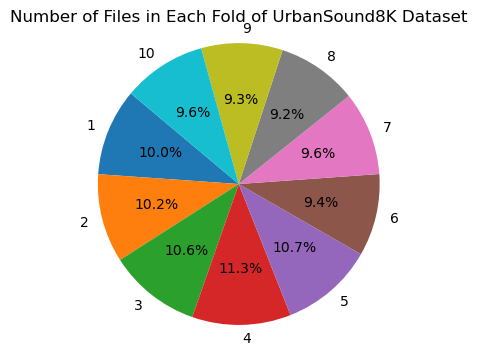

In [9]:
fold_counts = metadata['fold'].value_counts().sort_index()

plt.figure(figsize=(4, 4))
plt.pie(fold_counts, labels=fold_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Number of Files in Each Fold of UrbanSound8K Dataset')
plt.axis('equal') 
plt.show()

# II. EDA

Exploring a random audio sample `132016-9-0-6.wav` by printing the values of : 
* **Sample rate (sr)** : defines the number of samples per second taken from a analog signal to make adigital signal.
* **Amplitude**  : a measure of how high or low the wave extends from the x axis

In [10]:
filename = '/Users/macos/Desktop/Drdo/Audio_Classification/UrbanSound8K/audio/fold1/132016-9-0-6.wav'

In [11]:
lib_audio_data, sample_rate = librosa.load(filename)

In [12]:
lib_audio_data

array([-0.07869472, -0.11024831, -0.08400878, ..., -0.00586693,
        0.00208374,  0.01869803], dtype=float32)

In [13]:
sample_rate

22050

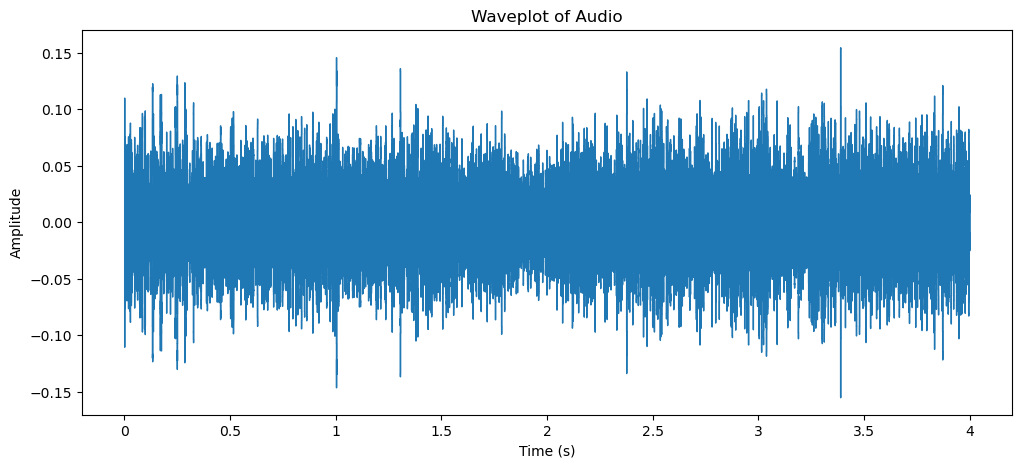

In [14]:
plt.figure(figsize=(12, 5))
librosa.display.waveshow(lib_audio_data, sr=sample_rate)
plt.title('Waveplot of Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Extracting Feautures

<font size="4">Mel Frequency Cepstral Coefficients (MFCC) </font> 

In [15]:
mfcc = librosa.feature.mfcc(y=lib_audio_data,sr=sample_rate,n_mfcc=40)
print(mfcc.shape)

(40, 173)


In [16]:
audio_dataset_path='UrbanSound8K/audio/'

In [17]:
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

In [18]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [19]:
import numpy as np
from tqdm import tqdm
import os

# Now we iterate through every audio file and extract features 
# using Mel-Frequency Cepstral Coefficients

extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [03:47, 14.79it/s]/Users/macos/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8325it [09:07, 23.21it/s]/Users/macos/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/Users/macos/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [09:31, 15.27it/s]


In [20]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.52066, 52.00812, -...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",children_playing


In [21]:
### Split the dataset into labels and target
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [22]:
X.shape

(8732, 40)

In [23]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [24]:
### Label Encoding

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

2024-07-23 22:52:34.193267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [27]:
X_train

array([[-1.31104706e+02,  1.12505905e+02, -2.25746956e+01, ...,
         3.24665213e+00, -1.36902380e+00,  2.75575471e+00],
       [-1.36703424e+01,  9.10850830e+01, -7.79273319e+00, ...,
        -3.25305080e+00, -5.27745295e+00, -1.55697155e+00],
       [-4.98715439e+01,  2.65352815e-01, -2.05009365e+01, ...,
         2.85459447e+00, -1.60920465e+00,  3.52480578e+00],
       ...,
       [-4.27012360e+02,  9.26230469e+01,  3.12939739e+00, ...,
         7.42641091e-01,  7.33490884e-01,  7.11009145e-01],
       [-1.45754608e+02,  1.36265778e+02, -3.35155182e+01, ...,
         1.46811950e+00, -2.00917006e+00, -8.82181883e-01],
       [-4.21031342e+02,  2.10654541e+02,  3.49066067e+00, ...,
        -5.38886738e+00, -3.37136054e+00, -1.56651151e+00]], dtype=float32)

In [28]:
X_train.shape

(6985, 40)

In [29]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
y_train.shape

(6985, 10)

In [31]:
y_test.shape

(1747, 10)

# Model

## ANN

In [32]:
import tensorflow as tf

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [34]:
num_labels=y.shape[1]

In [35]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [37]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
216/219 [============================>.] - ETA: 0s - loss: 12.3280 - accuracy: 0.1978
Epoch 1: val_loss improved from inf to 1.78683, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 3s 6ms/step - loss: 12.2334 - accuracy: 0.1980 - val_loss: 1.7868 - val_accuracy: 0.4030
Epoch 2/100
 42/219 [====>.........................] - ETA: 0s - loss: 3.0532 - accuracy: 0.2686

/Users/macos/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


203/219 [==========================>...] - ETA: 0s - loss: 2.6121 - accuracy: 0.2769
Epoch 2: val_loss improved from 1.78683 to 1.73434, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 2.5718 - accuracy: 0.2822 - val_loss: 1.7343 - val_accuracy: 0.4453
Epoch 3/100
203/219 [==========================>...] - ETA: 0s - loss: 2.0463 - accuracy: 0.3296
Epoch 3: val_loss improved from 1.73434 to 1.62710, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 3ms/step - loss: 2.0461 - accuracy: 0.3278 - val_loss: 1.6271 - val_accuracy: 0.4848
Epoch 4/100
204/219 [==========================>...] - ETA: 0s - loss: 1.8404 - accuracy: 0.3799
Epoch 4: val_loss improved from 1.62710 to 1.52546, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 1.8365 - accuracy: 0.3804 - val_loss: 1.5255 - val_accuracy: 0.5255
Epoch 5

219/219 [==============================] - 1s 4ms/step - loss: 1.0821 - accuracy: 0.6306 - val_loss: 0.8771 - val_accuracy: 0.7384
Epoch 27/100
205/219 [===========================>..] - ETA: 0s - loss: 1.0685 - accuracy: 0.6378
Epoch 27: val_loss did not improve from 0.87714
219/219 [==============================] - 1s 4ms/step - loss: 1.0730 - accuracy: 0.6359 - val_loss: 0.8784 - val_accuracy: 0.7247
Epoch 28/100
211/219 [===========================>..] - ETA: 0s - loss: 1.0647 - accuracy: 0.6413
Epoch 28: val_loss did not improve from 0.87714
219/219 [==============================] - 1s 4ms/step - loss: 1.0645 - accuracy: 0.6419 - val_loss: 0.8941 - val_accuracy: 0.7184
Epoch 29/100
213/219 [============================>.] - ETA: 0s - loss: 1.0366 - accuracy: 0.6486
Epoch 29: val_loss did not improve from 0.87714
219/219 [==============================] - 1s 3ms/step - loss: 1.0404 - accuracy: 0.6480 - val_loss: 0.8831 - val_accuracy: 0.7172
Epoch 30/100
207/219 [================

208/219 [===========================>..] - ETA: 0s - loss: 0.9322 - accuracy: 0.6800
Epoch 53: val_loss improved from 0.75459 to 0.75305, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 0.9320 - accuracy: 0.6802 - val_loss: 0.7531 - val_accuracy: 0.7602
Epoch 54/100
206/219 [===========================>..] - ETA: 0s - loss: 0.9240 - accuracy: 0.6795
Epoch 54: val_loss did not improve from 0.75305
219/219 [==============================] - 1s 3ms/step - loss: 0.9211 - accuracy: 0.6809 - val_loss: 0.7583 - val_accuracy: 0.7659
Epoch 55/100
208/219 [===========================>..] - ETA: 0s - loss: 0.9101 - accuracy: 0.6889
Epoch 55: val_loss improved from 0.75305 to 0.75013, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 3ms/step - loss: 0.9076 - accuracy: 0.6899 - val_loss: 0.7501 - val_accuracy: 0.7808
Epoch 56/100
218/219 [============================>.] - ETA: 0

219/219 [==============================] - 1s 5ms/step - loss: 0.8804 - accuracy: 0.6953 - val_loss: 0.7121 - val_accuracy: 0.7710
Epoch 81/100
217/219 [============================>.] - ETA: 0s - loss: 0.8487 - accuracy: 0.7077
Epoch 81: val_loss did not improve from 0.70012
219/219 [==============================] - 1s 4ms/step - loss: 0.8478 - accuracy: 0.7081 - val_loss: 0.7037 - val_accuracy: 0.7785
Epoch 82/100
207/219 [===========================>..] - ETA: 0s - loss: 0.8715 - accuracy: 0.6937
Epoch 82: val_loss improved from 0.70012 to 0.69621, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 5ms/step - loss: 0.8697 - accuracy: 0.6945 - val_loss: 0.6962 - val_accuracy: 0.7922
Epoch 83/100
202/219 [==========================>...] - ETA: 0s - loss: 0.8668 - accuracy: 0.6988
Epoch 83: val_loss did not improve from 0.69621
219/219 [==============================] - 1s 4ms/step - loss: 0.8630 - accuracy: 0.6989 - val_loss: 0.7227 -

## ACCURACY

In [39]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7727532982826233


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 

55/55 [==============================] - 0s 2ms/step


In [42]:
y_true_classes = np.argmax(y_test, axis=1)  

class_names = [f'Class {i}' for i in range(10)] 
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.62      0.87      0.72       195
     Class 1       1.00      0.69      0.82        91
     Class 2       0.54      0.80      0.64       205
     Class 3       0.84      0.70      0.77       182
     Class 4       0.90      0.83      0.86       202
     Class 5       0.95      0.78      0.86       216
     Class 6       0.98      0.55      0.71        87
     Class 7       0.88      0.90      0.89       187
     Class 8       0.98      0.82      0.89       199
     Class 9       0.60      0.60      0.60       183

    accuracy                           0.77      1747
   macro avg       0.83      0.75      0.78      1747
weighted avg       0.81      0.77      0.78      1747

